In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
from scipy import ndimage
from scipy.interpolate import griddata
from IPython.display import display, Markdown, Latex

%matplotlib inline

In [2]:
import TileUtility
HT = TileUtility.HalfTiles(TileUtility.FullTiles())

In [3]:
# Takes a 5x5 array of terrains (0,1,2,3,4,5) and crowns (0, 1, 2, 3)
#  and returns score per kingdomino rules
#  size of each contiguous region as defined by orthogonal adjacency
#   times the number of crowns within that region
def scoreDomino(terrain, crowns):
    visited = np.zeros((5,5), 'uint8')
    score = []
    
    for I in range(25):
        i, j = I // 5, I % 5
    
        # If we haven't seen this tile yet and it's an actual tile
        # as opposed to the home tile or the table top
        if visited[i, j] == 0 and terrain[i, j] >= 0 and terrain[i, j] < 6:
            
            # Add to the queue
            queue = [(i, j)]
            T = terrain[i, j]
            C = 0  # Crowns
            N = 0  # Tiles

            # While the queue is not empty,
            #  tally up the crowns and add other adjacent tiles
            #  of the same terrain to the queue.
            current = []
            while len(queue) > 0:
                x, y = queue.pop(0)
                
                # This is needed because the same tile could be added by multiple
                # neighbors.  I can probably get rid of this with a rewrite..
                if visited[x, y] == 1: continue

                C = C + crowns[x, y]
                N = N + 1
                visited[x, y] = 1
                current.append((x,y))

                neighbors = [ (x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1) ]
                for xx, yy in neighbors:
                    # Make the sure the tile is inbounds
                    if (xx < 0 or xx > 4 or yy < 0 or yy > 4): continue
                    # ...and it is the right terrain
                    if terrain[xx, yy] != T: continue
                    # ...and we haven't already visited it once
                    if visited[xx, yy] == 1: continue
                    queue.append((xx, yy))

            score.append({"tiles": current, "terrain": TileUtility.itot(T), "crowns": C, "numtiles": N, "total": C*N})
    return score

def prettyPrintScore(score):   
    row  = "| Region | Tiles | Crowns | Subtotal | Tiles |\n"
    row += "| ---    | ---:   | ---:    | ---: | :---  |\n"
    letters = "ABCDE"
    subtotal = 0
    for i, s in enumerate(score):
        subtotal += s["total"]
        row = row + "| " + s["terrain"] + " | " + str(s["numtiles"]) + " | " + str(s["crowns"])
        row = row + " | " + str(s["total"])  + " | "
        
        temp = ""
        for t in s["tiles"]:
            temp += letters[t[1]] + str(t[0]) + ","
        temp = temp[0:len(temp)-1]
        row = row + temp + " |\n"
    row += "| __Total__  | | | " + str(subtotal) + " | |\n"
    return row

# Score for Board 193745
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| swamp | 3 | 0 | 0 | A0,B0,C0 |
| mine | 2 | 2 | 4 | D0,E0 |
| desert | 7 | 2 | 14 | A1,B1,C1,D1,D2,E1,E2 |
| grass | 1 | 1 | 1 | A2 |
| ocean | 4 | 0 | 0 | B2,B3,B4,A3 |
| forest | 6 | 2 | 12 | C2,C3,C4,D4,E4,E3 |
| grass | 1 | 1 | 1 | A4 |
| __Total__  | | | 32 | |


# Score for Board 135938
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| mine | 2 | 1 | 2 | A0,A1 |
| desert | 4 | 2 | 8 | B0,B1,B2,B3 |
| grass | 1 | 0 | 0 | C0 |
| swamp | 4 | 3 | 12 | D0,D1,C1,E1 |
| desert | 1 | 0 | 0 | E0 |
| grass | 4 | 2 | 8 | A2,A3,A4,B4 |
| forest | 1 | 0 | 0 | D2 |
| ocean | 5 | 3 | 15 | E2,E3,E4,D4,C4 |
| forest | 1 | 0 | 0 | C3 |
| desert | 1 | 0 | 0 | D3 |
| __Total__  | | | 45 | |


# Score for Board 193730
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| grass | 6 | 2 | 12 | A0,A1,A2,A3,B2,A4 |
| desert | 4 | 1 | 4 | B0,C0,D0,E0 |
| swamp | 3 | 1 | 3 | B1,C1,D1 |
| ocean | 5 | 3 | 15 | E1,E2,E3,D2,D3 |
| forest | 6 | 1 | 6 | B3,B4,C3,C4,D4,E4 |
| __Total__  | | | 40 | |


# Score for Board 195431
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| ocean | 9 | 3 | 27 | A0,A1,A2,A3,B3,C3,D3,D4,E3 |
| grass | 3 | 0 | 0 | B0,B1,C1 |
| desert | 3 | 1 | 3 | C0,D0,E0 |
| forest | 5 | 3 | 15 | D1,D2,E1,C2,E2 |
| desert | 2 | 0 | 0 | B4,C4 |
| __Total__  | | | 45 | |


# Score for Board 134428
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| forest | 1 | 1 | 1 | B0 |
| mine | 1 | 0 | 0 | C0 |
| swamp | 3 | 2 | 6 | D0,E0,E1 |
| desert | 9 | 3 | 27 | B1,B2,C1,A2,C2,D1,C3,D2,C4 |
| forest | 4 | 0 | 0 | A3,A4,B3,B4 |
| ocean | 3 | 1 | 3 | D3,D4,E3 |
| desert | 1 | 0 | 0 | E4 |
| __Total__  | | | 37 | |


# Score for Board 134434
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| desert | 1 | 0 | 0 | A0 |
| forest | 7 | 2 | 14 | B0,C0,D0,E0,E1,E2,D2 |
| grass | 4 | 2 | 8 | A1,A2,B1,A3 |
| ocean | 2 | 1 | 2 | C1,D1 |
| desert | 2 | 0 | 0 | B2,B3 |
| ocean | 8 | 3 | 24 | C3,C4,D3,B4,D4,E3,A4,E4 |
| __Total__  | | | 48 | |


# Score for Board 193728
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| grass | 6 | 2 | 12 | A0,A1,A2,A3,B2,A4 |
| desert | 4 | 1 | 4 | B0,C0,D0,E0 |
| swamp | 3 | 1 | 3 | B1,C1,D1 |
| ocean | 5 | 3 | 15 | E1,E2,E3,D2,D3 |
| forest | 6 | 1 | 6 | B3,B4,C3,C4,D4,E4 |
| __Total__  | | | 40 | |


# Score for Board 140316
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| ocean | 5 | 3 | 15 | A0,A1,B0,A2,C0 |
| grass | 4 | 2 | 8 | D0,E0,E1,E2 |
| desert | 1 | 0 | 0 | B1 |
| forest | 1 | 0 | 0 | C1 |
| desert | 4 | 2 | 8 | D1,D2,D3,D4 |
| forest | 1 | 0 | 0 | B2 |
| swamp | 4 | 1 | 4 | A3,B3,B4,C3 |
| mine | 2 | 1 | 2 | E3,E4 |
| desert | 1 | 0 | 0 | A4 |
| grass | 1 | 0 | 0 | C4 |
| __Total__  | | | 37 | |


# Score for Board 193747
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| swamp | 3 | 0 | 0 | A0,B0,C0 |
| mine | 2 | 2 | 4 | D0,E0 |
| desert | 7 | 2 | 14 | A1,B1,C1,D1,D2,E1,E2 |
| grass | 1 | 1 | 1 | A2 |
| ocean | 4 | 0 | 0 | B2,B3,B4,A3 |
| forest | 6 | 2 | 12 | C2,C3,C4,D4,E4,E3 |
| grass | 1 | 1 | 1 | A4 |
| __Total__  | | | 32 | |


# Score for Board 135929
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| ocean | 1 | 0 | 0 | A0 |
| forest | 9 | 3 | 27 | B0,B1,C0,A1,C1,A2,A3,A4,B3 |
| desert | 3 | 1 | 3 | D0,D1,E1 |
| swamp | 1 | 0 | 0 | E0 |
| desert | 1 | 0 | 0 | B2 |
| ocean | 3 | 1 | 3 | D2,E2,E3 |
| desert | 3 | 0 | 0 | C3,C4,D3 |
| grass | 1 | 0 | 0 | B4 |
| forest | 2 | 1 | 2 | D4,E4 |
| __Total__  | | | 35 | |


# Score for Board 134443
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| mine | 4 | 8 | 32 | A0,A1,A2,A3 |
| desert | 1 | 0 | 0 | B0 |
| forest | 4 | 0 | 0 | C0,D0,E0,E1 |
| swamp | 1 | 0 | 0 | B1 |
| desert | 3 | 0 | 0 | C1,D1,D2 |
| desert | 3 | 0 | 0 | B2,B3,C3 |
| swamp | 1 | 1 | 1 | E2 |
| ocean | 3 | 1 | 3 | D3,D4,E3 |
| forest | 1 | 1 | 1 | A4 |
| grass | 2 | 1 | 2 | B4,C4 |
| forest | 1 | 0 | 0 | E4 |
| __Total__  | | | 39 | |


# Score for Board 134431
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| desert | 1 | 0 | 0 | A0 |
| forest | 7 | 2 | 14 | B0,C0,D0,E0,E1,E2,D2 |
| grass | 4 | 2 | 8 | A1,A2,B1,A3 |
| ocean | 2 | 1 | 2 | C1,D1 |
| desert | 2 | 0 | 0 | B2,B3 |
| ocean | 8 | 3 | 24 | C3,C4,D3,B4,D4,E3,A4,E4 |
| __Total__  | | | 48 | |


# Score for Board 193734
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| grass | 6 | 2 | 12 | A0,A1,A2,A3,B2,A4 |
| desert | 4 | 1 | 4 | B0,C0,D0,E0 |
| swamp | 3 | 1 | 3 | B1,C1,D1 |
| ocean | 5 | 3 | 15 | E1,E2,E3,D2,D3 |
| forest | 6 | 1 | 6 | B3,B4,C3,C4,D4,E4 |
| __Total__  | | | 40 | |


# Score for Board 134441
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| mine | 4 | 8 | 32 | A0,A1,A2,A3 |
| desert | 1 | 0 | 0 | B0 |
| forest | 4 | 0 | 0 | C0,D0,E0,E1 |
| swamp | 1 | 0 | 0 | B1 |
| desert | 3 | 0 | 0 | C1,D1,D2 |
| desert | 3 | 0 | 0 | B2,B3,C3 |
| swamp | 1 | 1 | 1 | E2 |
| ocean | 3 | 1 | 3 | D3,D4,E3 |
| forest | 1 | 1 | 1 | A4 |
| grass | 2 | 1 | 2 | B4,C4 |
| forest | 1 | 0 | 0 | E4 |
| __Total__  | | | 39 | |


# Score for Board 193743
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| swamp | 3 | 0 | 0 | A0,B0,C0 |
| mine | 2 | 2 | 4 | D0,E0 |
| desert | 7 | 2 | 14 | A1,B1,C1,D1,D2,E1,E2 |
| grass | 1 | 1 | 1 | A2 |
| ocean | 4 | 0 | 0 | B2,B3,B4,A3 |
| forest | 6 | 2 | 12 | C2,C3,C4,D4,E4,E3 |
| grass | 1 | 1 | 1 | A4 |
| __Total__  | | | 32 | |


# Score for Board 195447
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| mine | 2 | 5 | 10 | A0,B0 |
| swamp | 2 | 0 | 0 | C0,D0 |
| grass | 8 | 6 | 48 | E0,E1,E2,E3,D3,C3,B3,A3 |
| desert | 1 | 0 | 0 | A1 |
| ocean | 4 | 0 | 0 | B1,C1,D1,D2 |
| forest | 2 | 0 | 0 | A2,B2 |
| desert | 5 | 0 | 0 | A4,B4,C4,D4,E4 |
| __Total__  | | | 58 | |


# Score for Board 132905
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| swamp | 7 | 5 | 35 | A0,A1,B0,B1,C1,D1,E1 |
| desert | 3 | 0 | 0 | C0,D0,E0 |
| grass | 10 | 5 | 50 | B2,B3,C2,B4,A3,C3,D2,D3,E2,E3 |
| desert | 1 | 0 | 0 | A4 |
| ocean | 1 | 0 | 0 | C4 |
| desert | 2 | 0 | 0 | D4,E4 |
| __Total__  | | | 85 | |


# Score for Board 193756
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| desert | 8 | 1 | 8 | A0,A1,B0,B1,B2,B3,B4,A3 |
| mine | 3 | 7 | 21 | C0,C1,D0 |
| swamp | 1 | 0 | 0 | E0 |
| ocean | 5 | 1 | 5 | D1,D2,E1,D3,E2 |
| grass | 1 | 0 | 0 | A2 |
| forest | 5 | 1 | 5 | C3,C4,D4,E4,E3 |
| forest | 1 | 1 | 1 | A4 |
| __Total__  | | | 40 | |


# Score for Board 193759
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| grass | 6 | 3 | 18 | A0,A1,A2,A3,B2,A4 |
| desert | 4 | 1 | 4 | B0,C0,D0,E0 |
| swamp | 3 | 0 | 0 | B1,C1,D1 |
| ocean | 5 | 3 | 15 | E1,E2,E3,D2,D3 |
| forest | 6 | 1 | 6 | B3,B4,C3,C4,D4,E4 |
| __Total__  | | | 43 | |


# Score for Board 195439
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| desert | 1 | 0 | 0 | A0 |
| forest | 6 | 3 | 18 | B0,C0,D0,D1,E0,E1 |
| mine | 2 | 3 | 6 | A1,A2 |
| desert | 9 | 2 | 18 | B1,B2,C1,B3,B4,C3,C4,D3,D4 |
| grass | 1 | 0 | 0 | D2 |
| ocean | 2 | 1 | 2 | E2,E3 |
| swamp | 2 | 2 | 4 | A3,A4 |
| mine | 1 | 0 | 0 | E4 |
| __Total__  | | | 48 | |


<ipython-input-4-43a69b4af9eb>:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


# Score for Board 135924
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| ocean | 1 | 0 | 0 | A0 |
| swamp | 1 | 2 | 2 | B0 |
| grass | 6 | 4 | 24 | C0,C1,C2,B1,B2,A1 |
| ocean | 1 | 0 | 0 | D0 |
| forest | 2 | 1 | 2 | D1,D2 |
| ocean | 1 | 1 | 1 | A2 |
| ocean | 1 | 0 | 0 | E2 |
| desert | 8 | 2 | 16 | A3,A4,B3,B4,C3,C4,D3,E3 |
| swamp | 1 | 0 | 0 | D4 |
| __Total__  | | | 45 | |


# Score for Board 132900
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| desert | 1 | 0 | 0 | A0 |
| grass | 10 | 5 | 50 | B0,B1,B2,A1,C1,B3,C2,B4,C3,C4 |
| swamp | 7 | 6 | 42 | D0,D1,E0,D2,E1,D3,D4 |
| ocean | 1 | 0 | 0 | A2 |
| desert | 3 | 0 | 0 | E2,E3,E4 |
| desert | 2 | 0 | 0 | A3,A4 |
| __Total__  | | | 92 | |


# Score for Board 132858
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| desert | 1 | 0 | 0 | A0 |
| grass | 10 | 5 | 50 | B0,B1,B2,A1,C1,B3,C2,B4,C3,C4 |
| swamp | 7 | 5 | 35 | D0,D1,E0,D2,E1,D3,D4 |
| ocean | 1 | 0 | 0 | A2 |
| desert | 3 | 0 | 0 | E2,E3,E4 |
| desert | 2 | 0 | 0 | A3,A4 |
| __Total__  | | | 85 | |


# Score for Board 132903
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| desert | 1 | 0 | 0 | A0 |
| grass | 10 | 5 | 50 | B0,B1,B2,A1,C1,B3,C2,B4,C3,C4 |
| swamp | 7 | 6 | 42 | D0,D1,E0,D2,E1,D3,D4 |
| ocean | 1 | 0 | 0 | A2 |
| desert | 3 | 0 | 0 | E2,E3,E4 |
| desert | 2 | 0 | 0 | A3,A4 |
| __Total__  | | | 92 | |


# Score for Board 193723
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| grass | 6 | 2 | 12 | A0,A1,A2,A3,B2,A4 |
| desert | 4 | 1 | 4 | B0,C0,D0,E0 |
| swamp | 3 | 1 | 3 | B1,C1,D1 |
| ocean | 5 | 3 | 15 | E1,E2,E3,D2,D3 |
| forest | 6 | 1 | 6 | B3,B4,C3,C4,D4,E4 |
| __Total__  | | | 40 | |


# Score for Board 193748
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| swamp | 3 | 0 | 0 | A0,B0,C0 |
| mine | 2 | 2 | 4 | D0,E0 |
| desert | 7 | 2 | 14 | A1,B1,C1,D1,D2,E1,E2 |
| grass | 1 | 1 | 1 | A2 |
| ocean | 4 | 0 | 0 | B2,B3,B4,A3 |
| forest | 6 | 2 | 12 | C2,C3,C4,D4,E4,E3 |
| grass | 1 | 1 | 1 | A4 |
| __Total__  | | | 32 | |


# Score for Board 135952
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| ocean | 1 | 0 | 0 | A0 |
| forest | 9 | 3 | 27 | B0,B1,C0,A1,C1,A2,A3,A4,B3 |
| desert | 3 | 1 | 3 | D0,D1,E1 |
| swamp | 1 | 0 | 0 | E0 |
| desert | 1 | 0 | 0 | B2 |
| ocean | 3 | 1 | 3 | D2,E2,E3 |
| desert | 3 | 0 | 0 | C3,C4,D3 |
| grass | 1 | 0 | 0 | B4 |
| forest | 2 | 1 | 2 | D4,E4 |
| __Total__  | | | 35 | |


# Score for Board 135922
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| ocean | 1 | 0 | 0 | A0 |
| swamp | 1 | 2 | 2 | B0 |
| grass | 6 | 4 | 24 | C0,C1,C2,B1,B2,A1 |
| ocean | 1 | 0 | 0 | D0 |
| forest | 2 | 1 | 2 | D1,D2 |
| ocean | 1 | 1 | 1 | A2 |
| ocean | 1 | 0 | 0 | E2 |
| desert | 8 | 2 | 16 | A3,A4,B3,B4,C3,C4,D3,E3 |
| swamp | 1 | 0 | 0 | D4 |
| __Total__  | | | 45 | |


# Score for Board 135942
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| forest | 1 | 0 | 0 | A0 |
| ocean | 5 | 1 | 5 | B0,B1,C0,A1,D0 |
| forest | 6 | 1 | 6 | E0,E1,E2,D1,E3,D2 |
| desert | 1 | 0 | 0 | C1 |
| swamp | 3 | 1 | 3 | A2,A3,A4 |
| mine | 4 | 9 | 36 | B2,B3,C3,D3 |
| desert | 4 | 0 | 0 | B4,C4,D4,E4 |
| __Total__  | | | 50 | |


# Score for Board 195443
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| forest | 6 | 3 | 18 | A0,A1,B0,A2,B1,A3 |
| ocean | 2 | 1 | 2 | C0,D0 |
| mine | 1 | 0 | 0 | E0 |
| grass | 1 | 0 | 0 | C1 |
| desert | 9 | 2 | 18 | D1,D2,E1,D3,E2,C3,E3,B3,B2 |
| desert | 1 | 0 | 0 | A4 |
| mine | 2 | 3 | 6 | B4,C4 |
| swamp | 2 | 2 | 4 | D4,E4 |
| __Total__  | | | 48 | |


# Score for Board 195508
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| swamp | 5 | 1 | 5 | A0,A1,B0,A2,C0 |
| desert | 1 | 0 | 0 | D0 |
| forest | 8 | 0 | 0 | E0,E1,E2,D2,D3,D4,C3,E4 |
| desert | 4 | 2 | 8 | B1,B2,B3,A3 |
| grass | 1 | 0 | 0 | C1 |
| ocean | 1 | 1 | 1 | D1 |
| grass | 1 | 0 | 0 | E3 |
| forest | 1 | 0 | 0 | A4 |
| ocean | 2 | 1 | 2 | B4,C4 |
| __Total__  | | | 16 | |


# Score for Board 134436
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| ocean | 1 | 0 | 0 | A0 |
| grass | 8 | 3 | 24 | B0,B1,C0,A1,C1,D0,D1,E1 |
| forest | 1 | 0 | 0 | E0 |
| desert | 6 | 2 | 12 | A2,A3,B2,B3,C3,C4 |
| swamp | 4 | 3 | 12 | D2,D3,E2,D4 |
| forest | 1 | 0 | 0 | E3 |
| forest | 2 | 2 | 4 | A4,B4 |
| ocean | 1 | 0 | 0 | E4 |
| __Total__  | | | 52 | |


# Score for Board 193753
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| swamp | 1 | 1 | 1 | A0 |
| desert | 2 | 0 | 0 | B0,C0 |
| grass | 4 | 2 | 8 | D0,D1,E0,D2 |
| desert | 1 | 0 | 0 | A1 |
| forest | 3 | 1 | 3 | B1,B2,A2 |
| mine | 1 | 1 | 1 | C1 |
| desert | 1 | 0 | 0 | E1 |
| ocean | 3 | 2 | 6 | E2,E3,E4 |
| grass | 1 | 0 | 0 | A3 |
| swamp | 2 | 4 | 8 | B3,C3 |
| forest | 1 | 0 | 0 | D3 |
| ocean | 1 | 0 | 0 | A4 |
| desert | 3 | 1 | 3 | B4,C4,D4 |
| __Total__  | | | 30 | |


# Score for Board 132857
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| desert | 1 | 0 | 0 | A0 |
| grass | 10 | 4 | 40 | B0,B1,B2,A1,C1,B3,C2,B4,C3,C4 |
| swamp | 6 | 4 | 24 | D0,D1,E0,D2,E1,D3 |
| ocean | 1 | 0 | 0 | A2 |
| desert | 3 | 0 | 0 | E2,E3,E4 |
| desert | 2 | 0 | 0 | A3,A4 |
| forest | 1 | 0 | 0 | D4 |
| __Total__  | | | 64 | |


# Score for Board 134449
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| forest | 1 | 1 | 1 | B0 |
| mine | 1 | 0 | 0 | C0 |
| swamp | 3 | 2 | 6 | D0,E0,E1 |
| desert | 9 | 3 | 27 | B1,B2,C1,A2,C2,D1,C3,D2,C4 |
| forest | 4 | 0 | 0 | A3,A4,B3,B4 |
| ocean | 3 | 1 | 3 | D3,D4,E3 |
| desert | 1 | 0 | 0 | E4 |
| __Total__  | | | 37 | |


# Score for Board 134446
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| ocean | 1 | 0 | 0 | A0 |
| grass | 8 | 3 | 24 | B0,B1,C0,A1,C1,D0,D1,E1 |
| forest | 1 | 0 | 0 | E0 |
| desert | 6 | 2 | 12 | A2,A3,B2,B3,C3,C4 |
| swamp | 4 | 3 | 12 | D2,D3,E2,D4 |
| forest | 1 | 0 | 0 | E3 |
| forest | 2 | 2 | 4 | A4,B4 |
| ocean | 1 | 0 | 0 | E4 |
| __Total__  | | | 52 | |


# Score for Board 135947
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| ocean | 1 | 0 | 0 | A0 |
| swamp | 1 | 2 | 2 | B0 |
| grass | 6 | 4 | 24 | C0,C1,C2,B1,B2,A1 |
| ocean | 1 | 0 | 0 | D0 |
| forest | 2 | 1 | 2 | D1,D2 |
| ocean | 1 | 1 | 1 | A2 |
| ocean | 1 | 0 | 0 | E2 |
| desert | 8 | 2 | 16 | A3,A4,B3,B4,C3,C4,D3,E3 |
| swamp | 1 | 0 | 0 | D4 |
| __Total__  | | | 45 | |


# Score for Board 134426
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| forest | 1 | 1 | 1 | B0 |
| mine | 1 | 0 | 0 | C0 |
| swamp | 3 | 2 | 6 | D0,E0,E1 |
| desert | 9 | 3 | 27 | B1,B2,C1,A2,C2,D1,C3,D2,C4 |
| forest | 4 | 0 | 0 | A3,A4,B3,B4 |
| ocean | 4 | 1 | 4 | D3,D4,E3,E4 |
| __Total__  | | | 38 | |


# Score for Board 193726
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| grass | 6 | 2 | 12 | A0,A1,A2,A3,B2,A4 |
| desert | 4 | 1 | 4 | B0,C0,D0,E0 |
| swamp | 3 | 1 | 3 | B1,C1,D1 |
| ocean | 5 | 3 | 15 | E1,E2,E3,D2,D3 |
| forest | 6 | 1 | 6 | B3,B4,C3,C4,D4,E4 |
| __Total__  | | | 40 | |


# Score for Board 195436
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| ocean | 9 | 3 | 27 | A0,A1,A2,A3,B3,C3,D3,D4,E3 |
| grass | 3 | 0 | 0 | B0,B1,C1 |
| desert | 3 | 1 | 3 | C0,D0,E0 |
| forest | 5 | 3 | 15 | D1,D2,E1,C2,E2 |
| desert | 2 | 0 | 0 | B4,C4 |
| __Total__  | | | 45 | |


# Score for Board 135943
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| forest | 1 | 0 | 0 | A0 |
| ocean | 5 | 1 | 5 | B0,B1,C0,A1,D0 |
| forest | 6 | 1 | 6 | E0,E1,E2,D1,E3,D2 |
| desert | 1 | 0 | 0 | C1 |
| swamp | 3 | 1 | 3 | A2,A3,A4 |
| mine | 4 | 9 | 36 | B2,B3,C3,D3 |
| desert | 4 | 0 | 0 | B4,C4,D4,E4 |
| __Total__  | | | 50 | |


# Score for Board 135920
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| ocean | 1 | 0 | 0 | A0 |
| swamp | 1 | 2 | 2 | B0 |
| grass | 6 | 4 | 24 | C0,C1,C2,B1,B2,A1 |
| ocean | 1 | 0 | 0 | D0 |
| forest | 2 | 1 | 2 | D1,D2 |
| ocean | 1 | 1 | 1 | A2 |
| ocean | 1 | 0 | 0 | E2 |
| desert | 8 | 2 | 16 | A3,A4,B3,B4,C3,C4,D3,E3 |
| swamp | 1 | 0 | 0 | D4 |
| __Total__  | | | 45 | |


# Score for Board 195506
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| forest | 8 | 0 | 0 | A0,A1,A2,B2,B3,B4,C3,A4 |
| desert | 1 | 0 | 0 | B0 |
| swamp | 5 | 3 | 15 | C0,D0,E0,E1,E2 |
| ocean | 1 | 1 | 1 | B1 |
| grass | 1 | 0 | 0 | C1 |
| desert | 4 | 2 | 8 | D1,D2,D3,E3 |
| grass | 1 | 0 | 0 | A3 |
| ocean | 2 | 1 | 2 | C4,D4 |
| forest | 1 | 0 | 0 | E4 |
| __Total__  | | | 26 | |


# Score for Board 195451
| Region | Tiles | Crowns | Subtotal | Tiles |
| ---    | ---:   | ---:    | ---: | :---  |
| desert | 5 | 0 | 0 | A0,B0,C0,D0,E0 |
| grass | 8 | 6 | 48 | A1,A2,B1,A3,C1,A4,D1,E1 |
| ocean | 4 | 0 | 0 | B2,B3,C3,D3 |
| forest | 2 | 0 | 0 | D2,E2 |
| desert | 1 | 0 | 0 | E3 |
| swamp | 2 | 1 | 2 | B4,C4 |
| mine | 2 | 5 | 10 | D4,E4 |
| __Total__  | | | 60 | |


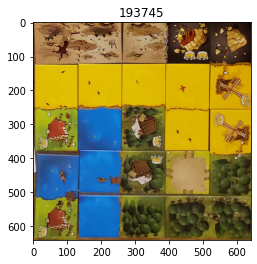

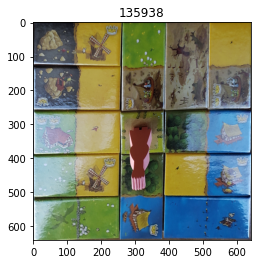

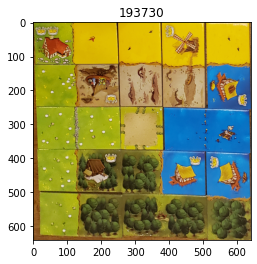

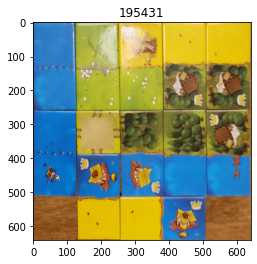

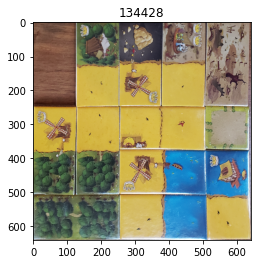

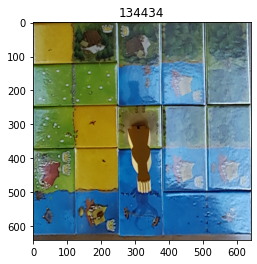

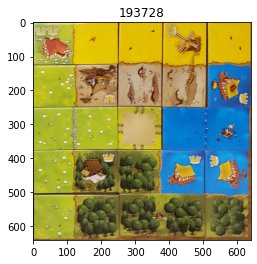

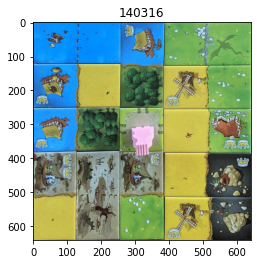

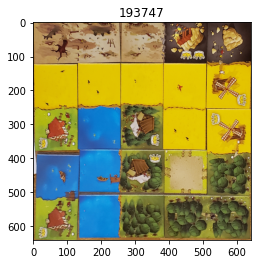

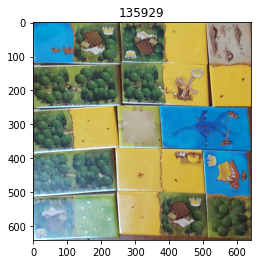

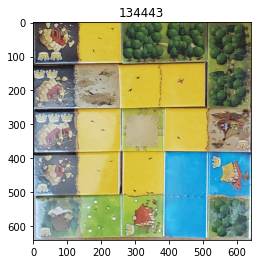

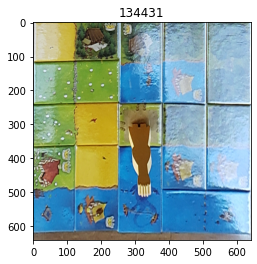

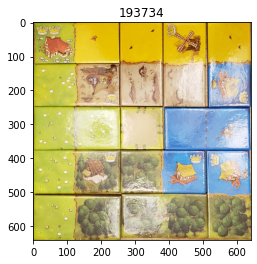

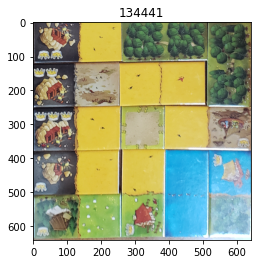

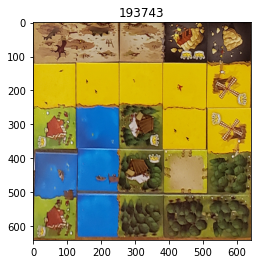

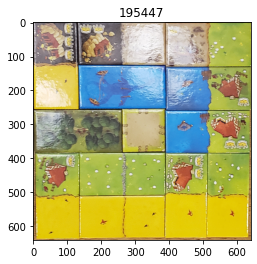

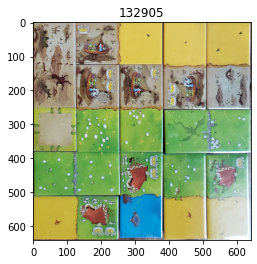

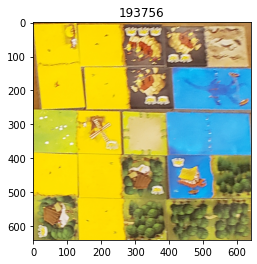

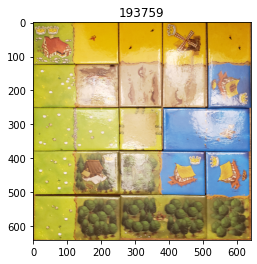

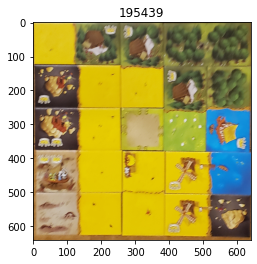

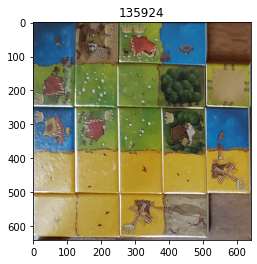

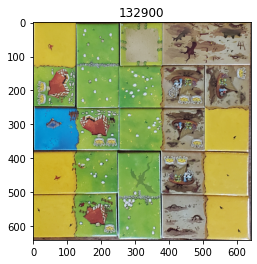

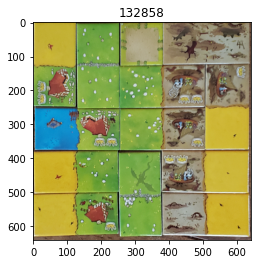

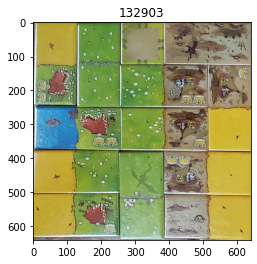

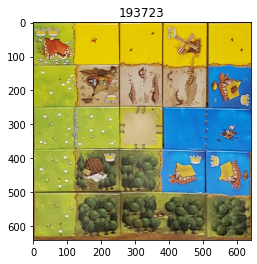

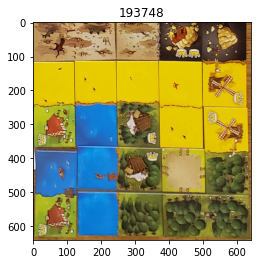

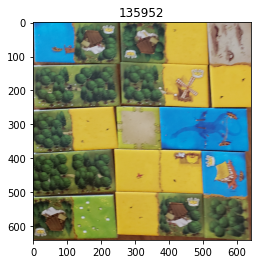

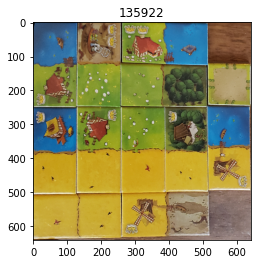

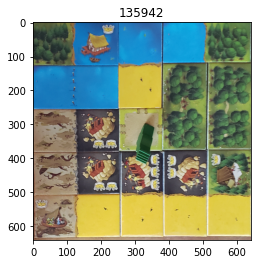

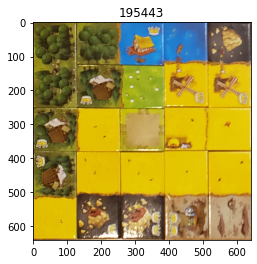

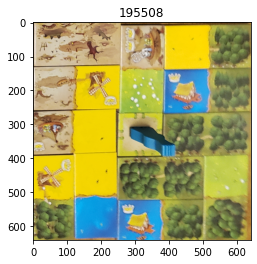

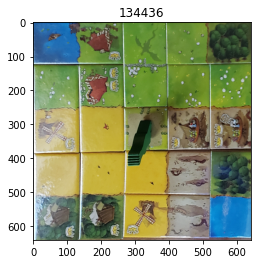

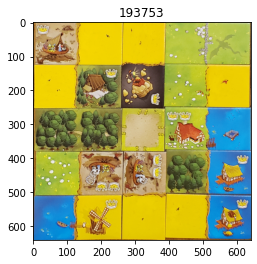

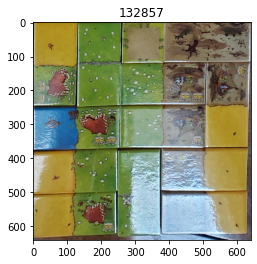

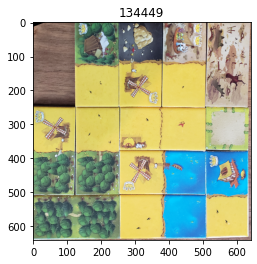

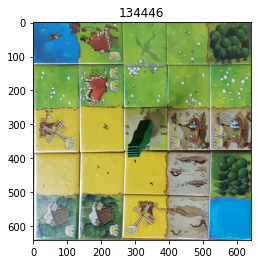

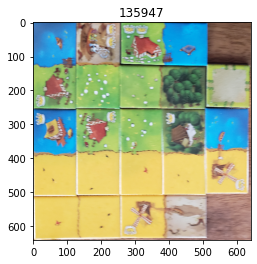

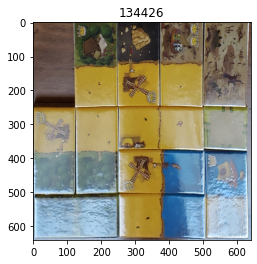

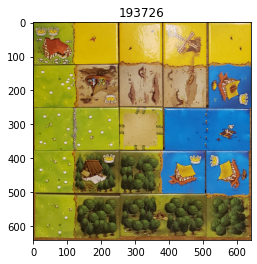

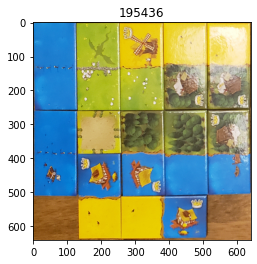

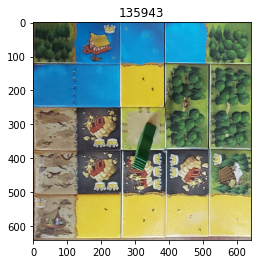

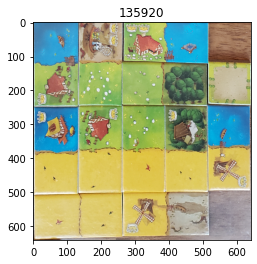

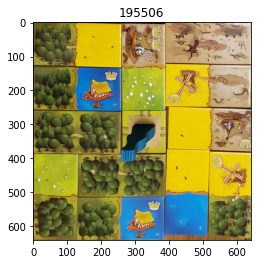

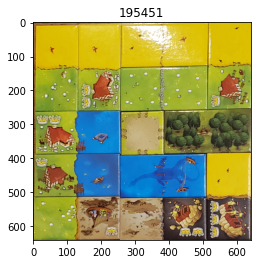

In [4]:
# Some test data to work out the kinks.

corners = {
    "195508": [ (2568, 2769), (2074, 1984), (2975, 1686), (3750, 2294) ],
    "195451": [ (1521, 672), (605, 1354), (1964, 2064), (2632, 1126)],
    "195443": [ (322, 1373), (1547, 1646), (1956, 673), (931, 522)],
    "193723": [ (958, 1805), (3176, 1730), (2702, 887), (1312, 920) ],
    "193726": [ (102, 2437), (2549, 2204), (2213, 817), (593, 888) ],
    "193728": [ (1671, 1962), (3600, 2242), (3064, 911), (1677, 499) ],
    "193743": [ (2078, 1316), (3255, 1312), (3034, 697), (2099, 703) ],
    "195431": [ (344, 2326), (2719, 1997), (2232, 732), (567, 795) ],
    "195506": [ (491, 1677), (2185, 2115), (2656, 776), (1293, 617) ],    
    
    "193745": [ (2326, 1232), (4038,1149), (3571, 133), (2242, 194)],
    "193730": [ (685, 2102), (2520, 1714), (2367, 495), (1045, 888)],
    "193734": [ (813, 2594), (2743, 2515), (2548, 830), (937, 859)],
    "193753": [ (1239, 1730), (2255, 2718), (3271, 1693), (2201, 1094)],
    "195436": [ (366, 1898), (1656, 1936), (1777, 852), (662, 850)],
    "193748": [ (1788, 1540), (3120, 1528), (2879, 727), (1821, 722)],
    "193747": [ (1111, 1879), (2928, 1809), (2656, 611), (1255, 627)],
    "195447": [ (1251, 1962), (2540, 1834), (2259, 863), (1123, 875)],
    "193756": [ (2065, 1160), (2846, 1065), (3424, 1677), (2532, 1859)],
    "193759": [ (834, 2689), (3552, 2838), (3296, 545), (1189, 504)],
    "195439": [ (950, 2284), (2693, 2094), (2354, 1024), (1049, 1090)]  ,
    
    "132857": [ (656, 1553), (3569, 1607), (2920, 499), (1222, 425) ],
    "132858": [ (1177, 2474), (3110, 2433), (2792, 1148), (1425, 1173) ],
    "132900": [ (966, 1978), (3024, 2082), (2598, 768), (1098, 421) ],
    "132903": [ (491, 2557), (1871, 2284), (1978, 999), (941, 1355) ],
    "132905": [ (-17, 1432), (2577, 2082), (2456, 660), (688, 121) ],
    "134426": [ (516, 1718), (3209, 1590), (2615, 640), (987, 673) ],
    "134428": [ (805, 2895), (3705, 1668), (2288, 380), (289, 698) ],
    "134431": [ (1462, 1350), (2648, 1309), (2420, 867), (1530, 879) ],
    "134434": [ (466, 1987), (1821, 1759), (1507, 1305), (508, 1396) ],
    "134436": [ (789, 2086), (2701, 2234), (2792, 929), (1421, 1008) ],
    "134441": [ (884, 1706), (2858, 1437), (2420, 392), (1016, 557) ],
    "134443": [ (867, 1743), (2606, 1879), (2656, 983), (1408, 933) ],
    "134446": [ (685, 1933), (2408, 2156), (2648, 747), (1276, 751) ],
    "134449": [ (1050, 3094), (3876, 1919), (2579, 44), (484, 745) ],
    "135920": [ (768, 1615), (3081, 1590), (2668, 342), (1098, 384) ],
    "135922": [ (-29, 2408), (2730, 2247), (2152, 917), (479, 875) ],
    "135924": [ (206, 2520), (1871, 2201), (1916, 1177), (772, 1462) ],
    "135929": [ (904, 1276), (2474, 2239), (3259, 896), (1958, 388) ],
    "135934": [ (739, 1611), (2751, 2119), (2879, 1049), (1512, 809) ],
    "135938": [ (871, 2234), (3606, 2193), (3036, 1103), (1437, 1181) ],
    "135942": [ (1177, 2396), (3205, 2470), (2982, 1069), (1549, 1103) ],
    "135943": [ (541, 1825), (2172, 1929), (2210, 974), (1024, 900) ],
    "135947": [ (272, 2726), (3738, 2520), (3011, 119), (656, 227) ],
    "135952": [ (355, 2168), (2429, 2565), (2573, 772), (974, 541) ],
    "140316": [ (104, 2518), (1977, 2497), (1799, 1075), (340, 1096) ]
}

tile_res = 128

for file in os.listdir('dev_images/'):
    label = (file.split("_")[1].split("."))[0]
    board = cv2.cvtColor(cv2.imread("dev_images/" + file), cv2.COLOR_BGR2RGB)

    if label not in corners:
        print("No labels for {0}".format(label))
        continue
    
    dst = np.array([[0, 0], [5*tile_res - 1, 0], [5*tile_res - 1, 5*tile_res - 1], [0, 5*tile_res - 1]], dtype="float32")
    src = np.array([[s[0],s[1]] for s in corners[label]], dtype="float32")

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(board, M, (5*tile_res, 5*tile_res))
    
    plt.figure()
    plt.title(label)
    plt.imshow(warped)

    terrain = np.zeros((5,5), 'uint8')
    crowns = np.zeros((5,5), 'uint8')
    tileCandidates = {}
    
    for i in range(5):
        for j in range(5):
            tile = warped[tile_res*i:tile_res*(i+1), tile_res*j:tile_res*(j+1)]
            terrain[i,j] = HT.predictTerrain(tile)
            crowns[i,j] = HT.predictCrowns(tile)
    
    score = scoreDomino(terrain, crowns)
    markdown = prettyPrintScore(score)
    markdown = "# Score for Board " + label + "\n" + markdown
    display(Markdown(markdown))


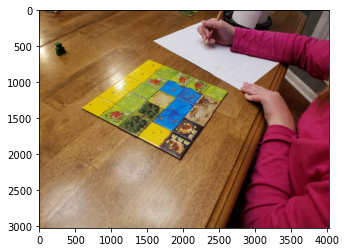

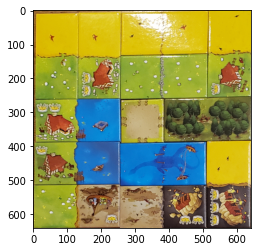

In [5]:
tile_res = 128

board = cv2.cvtColor(cv2.imread("dev_images/20201102_195451.jpg"), cv2.COLOR_BGR2RGB)
label = "195451"
plt.figure()
plt.imshow(board)

dst = np.array([[0, 0], [5*tile_res - 1, 0], [5*tile_res - 1, 5*tile_res - 1], [0, 5*tile_res - 1]], dtype="float32")
src = np.array([[s[0],s[1]] for s in corners[label]], dtype="float32")

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(board, M, (5*tile_res, 5*tile_res))
    
plt.figure()
plt.imshow(warped)

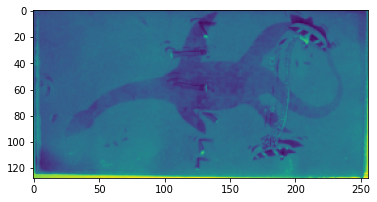

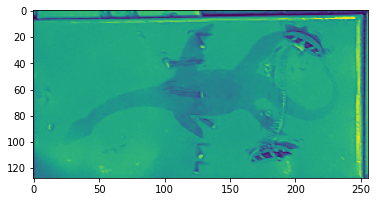

In [6]:
# TX defines the transforrmation we need to do on pristine dominos to get them
#  to rightg orientation on player board.
def TX(im):
    return np.flip(im, axis = 0)

# Orig Domino corresponds to the domino we are replacing
origDomino = TX(cv2.cvtColor(cv2.imread("processed_tiles/cropped_tile_07.png"), cv2.COLOR_BGR2Lab))

# And this is the domino that we will replce it with
replDomino = np.fliplr(cv2.cvtColor(cv2.imread("processed_tiles/cropped_tile_45.png"), cv2.COLOR_BGR2Lab))

plt.figure()
plt.imshow(origDomino[:,:,0])

# This is the domino in the actual image. We will use the difference in contrast between this
#  and the pristine to do a faux relighting
wildDomino = cv2.cvtColor(warped[3*tile_res:4*tile_res, 2*tile_res:4*tile_res], cv2.COLOR_BGR2Lab)
plt.figure()
plt.imshow(wildDomino[:,:,0])

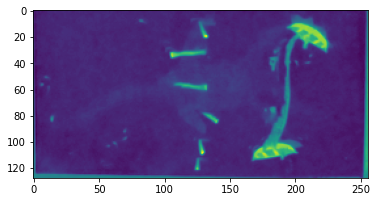

In [24]:
plt.imshow(origDomino[:, :, 2])

In [16]:
np.histogram(origDomino[:,:,0] - wildDomino[:, :, 0])

(array([ 1126,   553,   606,   380,   160,   135,   476,  2102, 22115,
         5115]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]))

In [17]:
scale = np.mean(wildDomino, axis=(0, 1)) - np.mean(origDomino, axis = (0, 1))
scale[1] = 1
scale[2] = 1
print(scale)

[30.34066772  1.          1.        ]


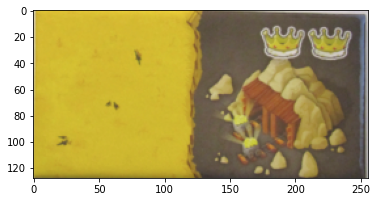

In [18]:
test = replDomino.copy() + scale
test2 = cv2.cvtColor(test.astype('uint8'), cv2.COLOR_Lab2RGB)
plt.imshow(test2)

In [19]:
Minv = np.linalg.inv(M)

warpedC = warped.copy()
warpedC[3*tile_res:4*tile_res, 2*tile_res:4*tile_res] = test2

# Project this back onto the original image using hte inverse persepctive
dst2 = np.array([[3, 2], [4, 2], [4, 4], [3, 4]])
warped2 = cv2.warpPerspective(warpedC, Minv, (board.shape[1], board.shape[0]))
mask = (warped2 != 0)

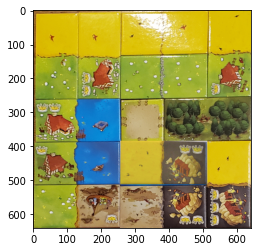

In [20]:
plt.imshow(warpedC)

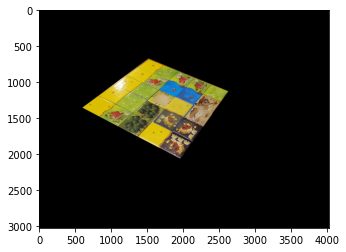

In [21]:
plt.imshow(warped2)

In [13]:
mask.shape

(3024, 4032, 3)

In [14]:
newboard = (1 - mask)*board + mask*warped2

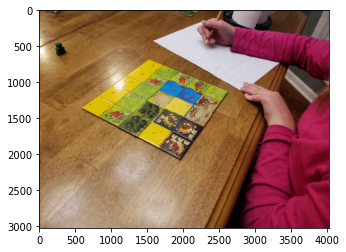

In [15]:
plt.imshow(newboard)